In [1]:
from datetime import datetime
from itertools import combinations

import pandas as pd
import numpy as np

from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

import matplotlib.pyplot as plt
%matplotlib inline

## Import Prices and Calculate Log Returns

In [2]:
def loadPriceRet(path, columns, period=("04-2020", "12-2020")):
    """Function to load price and calculate log returns"""
    
    df = pd.read_csv(path)
    
    df.index = df['Date'].apply(lambda x: datetime(int(x[:4]), int(x[5:7]), int(x[-2:])))
    
    colToDrop = [col for col in df.columns if col not in columns]
    df.drop(columns=colToDrop, inplace=True)
    
    retSeries = (np.log(df['Adj Close'] / df['Adj Close'].shift(1))) * 100
    df['Log Returns'] = retSeries
    
    df.dropna(inplace=True)
    
    df = df[period[0]:period[1]]
    
    return df

In [3]:
eqy = loadPriceRet('./SCHF.csv', columns=['Adj Close'])
gld = loadPriceRet('./GLD.csv', columns=['Adj Close'])
btc = loadPriceRet('./BTC-USD.csv', columns=['Adj Close'])

## Calculate Daily Returns

In [4]:
eqyDRet = eqy['Log Returns'].describe()['mean']
gldDRet = gld['Log Returns'].describe()['mean']
btcDRet = btc['Log Returns'].describe()['mean']

print('Daily Returns of SCHF: {:.4f}%'.format(eqyDRet))
print('Daily Returns of GLD: {:.4f}%'.format(gldDRet))
print('Daily Returns of BTC: {:.4f}%'.format(btcDRet))

Daily Returns of SCHF: 0.1854%
Daily Returns of GLD: 0.0961%
Daily Returns of BTC: 0.5473%


## Data Summaries (20-Day Moving Average)

In [5]:
def rollingMean(path, smaWindow=20, period=("04-2020", "12-2020")):
    
    df = loadPriceRet(path, columns=['Adj Close'], period=("01-2020", "12-2020"))
    
    rollMean = df['Adj Close'].rolling(smaWindow).mean()
    
    df['Rolling Mean'] = rollMean
    
    df = df[period[0]:period[1]]
    
    return df

In [6]:
eqy = rollingMean('./SCHF.csv')
gld = rollingMean('./GLD.csv')
btc = rollingMean('./BTC-USD.csv')

## Graphing Moving Averages

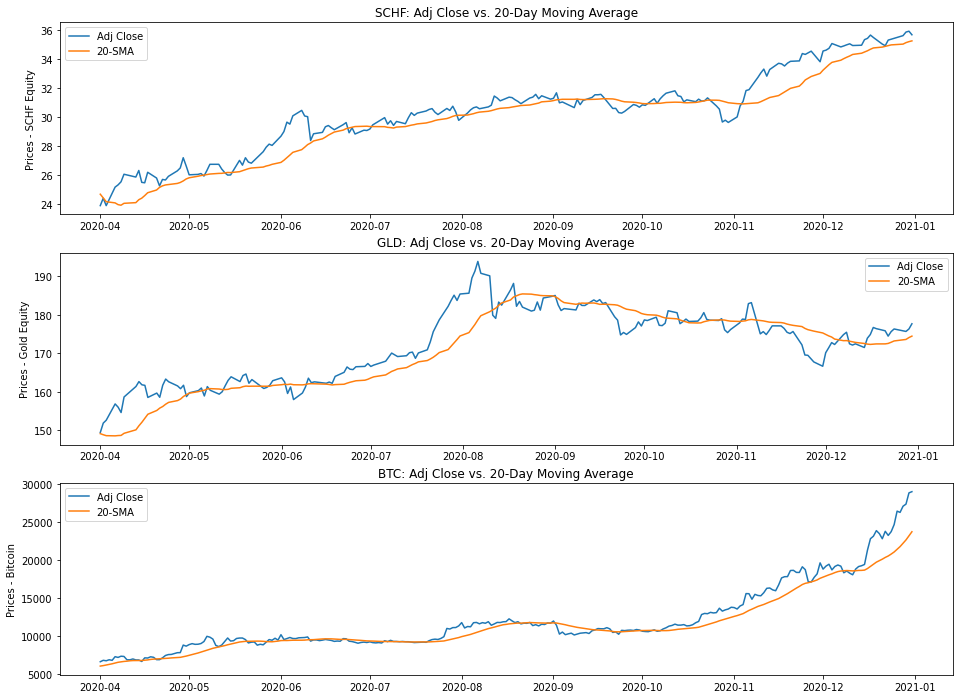

In [57]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12))

axes[0].plot(eqy['Adj Close'], label="Adj Close")
axes[0].plot(eqy['Rolling Mean'], label="20-SMA")
axes[0].set_ylabel(r"Prices - SCHF Equity")
axes[0].set_title("SCHF: Adj Close vs. 20-Day Moving Average")
axes[0].legend()

axes[1].plot(gld['Adj Close'], label="Adj Close")
axes[1].plot(gld['Rolling Mean'], label="20-SMA")
axes[1].set_ylabel(r"Prices - Gold Equity")
axes[1].set_title("GLD: Adj Close vs. 20-Day Moving Average")
axes[1].legend()

axes[2].plot(btc['Adj Close'], label="Adj Close")
axes[2].plot(btc['Rolling Mean'], label="20-SMA")
axes[2].set_ylabel(r"Prices - Bitcoin")
axes[2].set_title("BTC: Adj Close vs. 20-Day Moving Average")
axes[2].legend()

plt.show()

### Graphing Prices (GLD vs. SCHF)

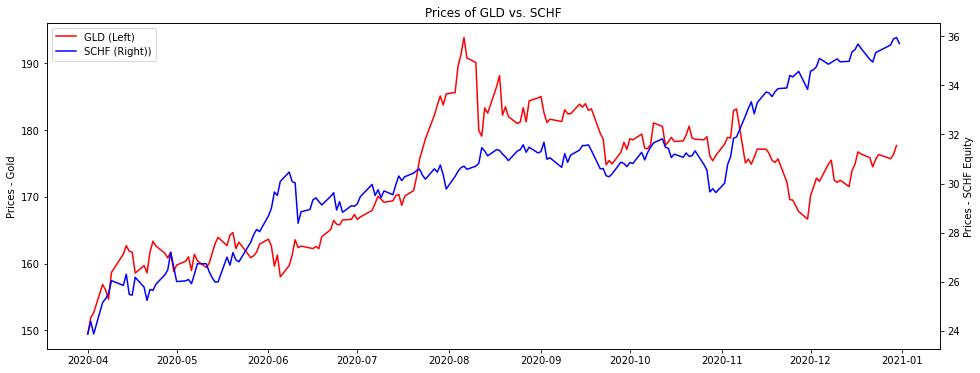

In [55]:
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = plt.twinx()

ax.plot(gld['Adj Close'], label="GLD (Left)", c="r")
ax2.plot(eqy['Adj Close'], label='SCHF (Right))', c="b")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc="upper left")

ax.set_ylabel(r"Prices - Gold")
ax2.set_ylabel(r"Prices - SCHF Equity")

plt.title("Prices of GLD vs. SCHF")
plt.show()

### Graphing Prices (GLD vs. BTC)

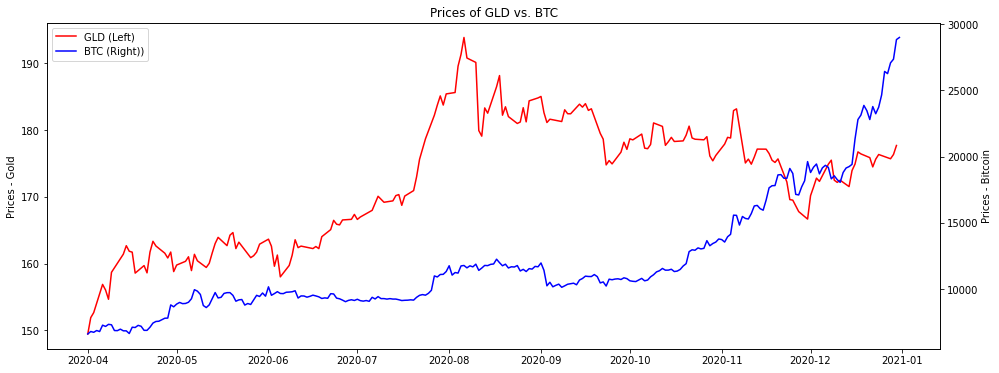

In [54]:
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = plt.twinx()

ax.plot(gld['Adj Close'], label="GLD (Left)", c="r")
ax2.plot(btc['Adj Close'], label="BTC (Right))", c="b")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc="upper left")

ax.set_ylabel(r"Prices - Gold")
ax2.set_ylabel(r"Prices - Bitcoin")

plt.title("Prices of GLD vs. BTC")
plt.show()

### Graphing Prices (SCHF vs. BTC)

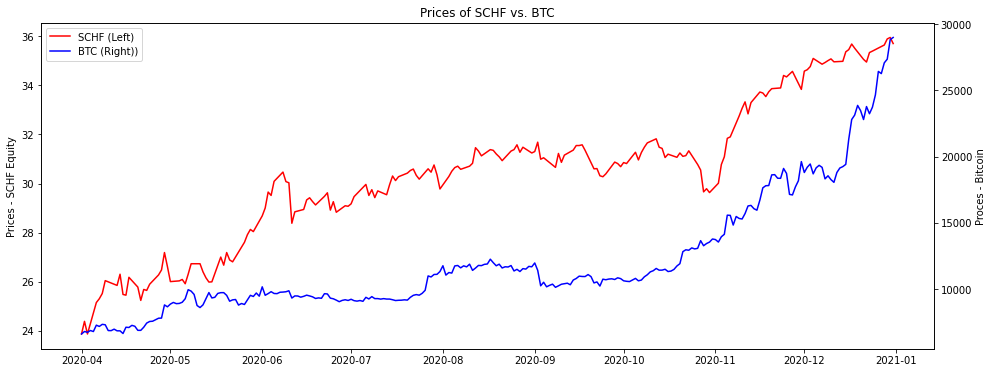

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = plt.twinx()

ax.plot(eqy['Adj Close'], label="SCHF (Left)", c="r")
ax2.plot(btc['Adj Close'], label="BTC (Right))", c="b")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc="upper left")

ax.set_ylabel(r"Prices - SCHF Equity")
ax2.set_ylabel(r"Proces - Bitcoin")

plt.title("Prices of SCHF vs. BTC")
plt.show()

## Fitting GARCH Model to Gold Returns

In [101]:
# Separating the data in quarters
eqyRQ2 = eqy['04-2020':'06-2020']['Log Returns']
gldRQ2 = gld['04-2020':'06-2020']['Log Returns']
btcRQ2 = btc.loc[eqyQ2.index, :]['Log Returns']

eqyRQ3 = eqy['07-2020':'09-2020']['Log Returns']
gldRQ3 = gld['07-2020':'09-2020']['Log Returns']
btcRQ3 = btc.loc[eqyQ3.index, :]['Log Returns']

eqyRQ4 = eqy['10-2020':'12-2020']['Log Returns']
gldRQ4 = gld['10-2020':'12-2020']['Log Returns']
btcRQ4 = btc.loc[eqyQ4.index, :]['Log Returns']

In [102]:
garchMDL = arch_model(y=gldRQ2, vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 89.87206121128484
Iteration:      2,   Func. Count:     14,   Neg. LLF: 89.58389144510417
Iteration:      3,   Func. Count:     22,   Neg. LLF: 89.58224090473696
Iteration:      4,   Func. Count:     29,   Neg. LLF: 89.51759401984435
Iteration:      5,   Func. Count:     36,   Neg. LLF: 89.45825997058292
Iteration:      6,   Func. Count:     42,   Neg. LLF: 89.06797393326877
Iteration:      7,   Func. Count:     48,   Neg. LLF: 88.92558944765811
Iteration:      8,   Func. Count:     54,   Neg. LLF: 88.73358090257668
Iteration:      9,   Func. Count:     61,   Neg. LLF: 88.04709101052231
Iteration:     10,   Func. Count:     67,   Neg. LLF: 88.03648983019889
Iteration:     11,   Func. Count:     73,   Neg. LLF: 88.03624134738338
Iteration:     12,   Func. Count:     79,   Neg. LLF: 88.03623995195153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.03623995196386
            Iterations: 12


In [103]:
garchMDL = arch_model(y=gldRQ3, vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 103.22069525072843
Iteration:      2,   Func. Count:     17,   Neg. LLF: 102.84779918408955
Iteration:      3,   Func. Count:     24,   Neg. LLF: 102.83526994116038
Iteration:      4,   Func. Count:     31,   Neg. LLF: 102.80136052741862
Iteration:      5,   Func. Count:     38,   Neg. LLF: 102.78481089095848
Iteration:      6,   Func. Count:     45,   Neg. LLF: 102.78415460334274
Iteration:      7,   Func. Count:     52,   Neg. LLF: 102.78271293304181
Iteration:      8,   Func. Count:     58,   Neg. LLF: 102.7826362900868
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 102.78263552031127
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log Returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squ

In [104]:
garchMDL = arch_model(y=gldRQ4, vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 91.36189853567116
Iteration:      2,   Func. Count:     15,   Neg. LLF: 91.35206852615023
Iteration:      3,   Func. Count:     22,   Neg. LLF: 91.34615543829906
Iteration:      4,   Func. Count:     28,   Neg. LLF: 91.23999090997496
Iteration:      5,   Func. Count:     34,   Neg. LLF: 91.22016759878751
Iteration:      6,   Func. Count:     41,   Neg. LLF: 91.21096905029061
Iteration:      7,   Func. Count:     48,   Neg. LLF: 91.20105162483495
Iteration:      8,   Func. Count:     55,   Neg. LLF: 91.19035806156613
Iteration:      9,   Func. Count:     62,   Neg. LLF: 91.17909690449983
Iteration:     10,   Func. Count:     71,   Neg. LLF: 91.17871043699756
Iteration:     11,   Func. Count:     78,   Neg. LLF: 91.16652339423922
Iteration:     12,   Func. Count:     85,   Neg. LLF: 91.15427271326043
Iteration:     13,   Func. Count:     92,   Neg. LLF: 91.14435244076137
Iteration:     14,   Func. Count:     99,   Neg. LLF: 91.1369496

## Fitting GARCH model for Gold Prices

In [52]:
eqyQ2 = eqy['04-2020':'06-2020']['Adj Close']
gldQ2 = gld['04-2020':'06-2020']['Adj Close']
btcQ2 = btc.loc[eqyQ2.index, :]['Adj Close']

eqyQ3 = eqy['07-2020':'09-2020']['Adj Close']
gldQ3 = gld['07-2020':'09-2020']['Adj Close']
btcQ3 = btc.loc[eqyQ3.index, :]['Adj Close']

eqyQ4 = eqy['10-2020':'12-2020']['Adj Close']
gldQ4 = gld['10-2020':'12-2020']['Adj Close']
btcQ4 = btc.loc[eqyQ4.index, :]['Adj Close']

btc.loc[eqyQ4.index, :]
# np.shape(btcQ3)
# np.shape(gld['Log Returns'])

,Adj Close,Log Returns,Rolling Mean
Date,,,
2020-10-01,10623.330078,-1.534648,10716.460400
2020-10-02,10585.164063,-0.359913,10723.610059
2020-10-05,10804.000977,1.112911,10736.228955
2020-10-06,10621.664063,-1.702083,10718.566895
2020-10-07,10679.136719,0.539630,10705.074219
...,...,...,...
2020-12-24,23735.949219,2.105791,20783.197656
2020-12-28,27084.808594,3.045804,22205.537891
2020-12-29,27362.437500,1.019818,22645.963965


In [46]:
garchMDL = arch_model(y=gldQ2, vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 149.16576015178862
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148.157265744476
Iteration:      3,   Func. Count:     22,   Neg. LLF: 147.43930730583048
Iteration:      4,   Func. Count:     29,   Neg. LLF: 145.78184124991728
Iteration:      5,   Func. Count:     36,   Neg. LLF: 145.42183193158374
Iteration:      6,   Func. Count:     42,   Neg. LLF: 144.3319858492053
Iteration:      7,   Func. Count:     48,   Neg. LLF: 144.2480031186106
Iteration:      8,   Func. Count:     54,   Neg. LLF: 144.21037126614794
Iteration:      9,   Func. Count:     60,   Neg. LLF: 144.1762636200753
Iteration:     10,   Func. Count:     66,   Neg. LLF: 144.1525999463472
Iteration:     11,   Func. Count:     72,   Neg. LLF: 144.12548087356856
Iteration:     12,   Func. Count:     78,   Neg. LLF: 144.1152758311139
Iteration:     13,   Func. Count:     84,   Neg. LLF: 144.11308259665168
Iteration:     14,   Func. Count:     90,   Neg. LLF: 144.

In [47]:
garchMDL = arch_model(y=gldQ3, vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 200.94498955308876
Iteration:      2,   Func. Count:     13,   Neg. LLF: 199.44875754580153
Iteration:      3,   Func. Count:     21,   Neg. LLF: 190.40110308536498
Iteration:      4,   Func. Count:     28,   Neg. LLF: 189.40668703148498
Iteration:      5,   Func. Count:     34,   Neg. LLF: 182.70068132444072
Iteration:      6,   Func. Count:     40,   Neg. LLF: 182.25187937659445
Iteration:      7,   Func. Count:     47,   Neg. LLF: 181.93313243923177
Iteration:      8,   Func. Count:     53,   Neg. LLF: 181.88414867463132
Iteration:      9,   Func. Count:     59,   Neg. LLF: 181.78973935262073
Iteration:     10,   Func. Count:     65,   Neg. LLF: 181.66607772377372
Iteration:     11,   Func. Count:     71,   Neg. LLF: 181.61099562015357
Iteration:     12,   Func. Count:     77,   Neg. LLF: 181.59956252791815
Iteration:     13,   Func. Count:     83,   Neg. LLF: 181.5992861107295
Iteration:     14,   Func. Count:     89,   Neg. LLF

In [42]:
garchMDL = arch_model(y=gldQ4, vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 158.31028948663993
Iteration:      2,   Func. Count:     13,   Neg. LLF: 153.34132455842666
Iteration:      3,   Func. Count:     20,   Neg. LLF: 152.7087425200862
Iteration:      4,   Func. Count:     27,   Neg. LLF: 151.08653005810746
Iteration:      5,   Func. Count:     33,   Neg. LLF: 149.63772951684146
Iteration:      6,   Func. Count:     40,   Neg. LLF: 149.61031190070887
Iteration:      7,   Func. Count:     46,   Neg. LLF: 149.60795212944376
Iteration:      8,   Func. Count:     52,   Neg. LLF: 149.60706219808333
Iteration:      9,   Func. Count:     58,   Neg. LLF: 149.60703824700042
Iteration:     10,   Func. Count:     64,   Neg. LLF: 149.60702805818022
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 149.6070279189352
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results     

## Fitting GARCH-M Model for Gold Returns

In [61]:
garchMMDL = arch_model(y=gldRQ2, mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gldRQ2, x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 89.87206121128484
Iteration:      2,   Func. Count:     14,   Neg. LLF: 89.58389144510417
Iteration:      3,   Func. Count:     22,   Neg. LLF: 89.58224090473696
Iteration:      4,   Func. Count:     29,   Neg. LLF: 89.51759401984435
Iteration:      5,   Func. Count:     36,   Neg. LLF: 89.45825997058292
Iteration:      6,   Func. Count:     42,   Neg. LLF: 89.06797393326877
Iteration:      7,   Func. Count:     48,   Neg. LLF: 88.92558944765811
Iteration:      8,   Func. Count:     54,   Neg. LLF: 88.73358090257668
Iteration:      9,   Func. Count:     61,   Neg. LLF: 88.04709101052231
Iteration:     10,   Func. Count:     67,   Neg. LLF: 88.03648983019889
Iteration:     11,   Func. Count:     73,   Neg. LLF: 88.03624134738338
Iteration:     12,   Func. Count:     79,   Neg. LLF: 88.03623995195153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.03623995196386
            Iterations: 12


In [62]:
garchMMDL = arch_model(y=gldRQ3, mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gldRQ3, x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 103.22069525072843
Iteration:      2,   Func. Count:     17,   Neg. LLF: 102.84779918408955
Iteration:      3,   Func. Count:     24,   Neg. LLF: 102.83526994116038
Iteration:      4,   Func. Count:     31,   Neg. LLF: 102.80136052741862
Iteration:      5,   Func. Count:     38,   Neg. LLF: 102.78481089095848
Iteration:      6,   Func. Count:     45,   Neg. LLF: 102.78415460334274
Iteration:      7,   Func. Count:     52,   Neg. LLF: 102.78271293304181
Iteration:      8,   Func. Count:     58,   Neg. LLF: 102.7826362900868
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 102.78263552031127
            Iterations: 8
            Function evaluations: 59
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 103.22069525072843
Iteration:      2,   Func. Count:     17,   Neg. LLF: 102.84779918408955
Iteration:      3,   Func. Count:     24,   Neg. LLF: 102.8352

In [63]:
garchMMDL = arch_model(y=gldRQ4, mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gldRQ4, x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 91.36189853567116
Iteration:      2,   Func. Count:     15,   Neg. LLF: 91.35206852615023
Iteration:      3,   Func. Count:     22,   Neg. LLF: 91.34615543829906
Iteration:      4,   Func. Count:     28,   Neg. LLF: 91.23999090997496
Iteration:      5,   Func. Count:     34,   Neg. LLF: 91.22016759878751
Iteration:      6,   Func. Count:     41,   Neg. LLF: 91.21096905029061
Iteration:      7,   Func. Count:     48,   Neg. LLF: 91.20105162483495
Iteration:      8,   Func. Count:     55,   Neg. LLF: 91.19035806156613
Iteration:      9,   Func. Count:     62,   Neg. LLF: 91.17909690449983
Iteration:     10,   Func. Count:     71,   Neg. LLF: 91.17871043699756
Iteration:     11,   Func. Count:     78,   Neg. LLF: 91.16652339423922
Iteration:     12,   Func. Count:     85,   Neg. LLF: 91.15427271326043
Iteration:     13,   Func. Count:     92,   Neg. LLF: 91.14435244076137
Iteration:     14,   Func. Count:     99,   Neg. LLF: 91.1369496

## Fitting GARCH-M Model for Gold Prices

In [64]:
garchMMDL = arch_model(y=gldQ2, mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gldQ2, x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 149.16576015178862
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148.157265744476
Iteration:      3,   Func. Count:     22,   Neg. LLF: 147.43930730583048
Iteration:      4,   Func. Count:     29,   Neg. LLF: 145.78184124991728
Iteration:      5,   Func. Count:     36,   Neg. LLF: 145.42183193158374
Iteration:      6,   Func. Count:     42,   Neg. LLF: 144.3319858492053
Iteration:      7,   Func. Count:     48,   Neg. LLF: 144.2480031186106
Iteration:      8,   Func. Count:     54,   Neg. LLF: 144.21037126614794
Iteration:      9,   Func. Count:     60,   Neg. LLF: 144.1762636200753
Iteration:     10,   Func. Count:     66,   Neg. LLF: 144.1525999463472
Iteration:     11,   Func. Count:     72,   Neg. LLF: 144.12548087356856
Iteration:     12,   Func. Count:     78,   Neg. LLF: 144.1152758311139
Iteration:     13,   Func. Count:     84,   Neg. LLF: 144.11308259665168
Iteration:     14,   Func. Count:     90,   Neg. LLF: 144.

In [65]:
garchMMDL = arch_model(y=gldQ3, mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gldQ3, x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 200.94498955308876
Iteration:      2,   Func. Count:     13,   Neg. LLF: 199.44875754580153
Iteration:      3,   Func. Count:     21,   Neg. LLF: 190.40110308536498
Iteration:      4,   Func. Count:     28,   Neg. LLF: 189.40668703148498
Iteration:      5,   Func. Count:     34,   Neg. LLF: 182.70068132444072
Iteration:      6,   Func. Count:     40,   Neg. LLF: 182.25187937659445
Iteration:      7,   Func. Count:     47,   Neg. LLF: 181.93313243923177
Iteration:      8,   Func. Count:     53,   Neg. LLF: 181.88414867463132
Iteration:      9,   Func. Count:     59,   Neg. LLF: 181.78973935262073
Iteration:     10,   Func. Count:     65,   Neg. LLF: 181.66607772377372
Iteration:     11,   Func. Count:     71,   Neg. LLF: 181.61099562015357
Iteration:     12,   Func. Count:     77,   Neg. LLF: 181.59956252791815
Iteration:     13,   Func. Count:     83,   Neg. LLF: 181.5992861107295
Iteration:     14,   Func. Count:     89,   Neg. LLF

In [66]:
garchMMDL = arch_model(y=gldQ4, mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gldQ4, x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 158.31028948663993
Iteration:      2,   Func. Count:     13,   Neg. LLF: 153.34132455842666
Iteration:      3,   Func. Count:     20,   Neg. LLF: 152.7087425200862
Iteration:      4,   Func. Count:     27,   Neg. LLF: 151.08653005810746
Iteration:      5,   Func. Count:     33,   Neg. LLF: 149.63772951684146
Iteration:      6,   Func. Count:     40,   Neg. LLF: 149.61031190070887
Iteration:      7,   Func. Count:     46,   Neg. LLF: 149.60795212944376
Iteration:      8,   Func. Count:     52,   Neg. LLF: 149.60706219808333
Iteration:      9,   Func. Count:     58,   Neg. LLF: 149.60703824700042
Iteration:     10,   Func. Count:     64,   Neg. LLF: 149.60702805818022
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 149.6070279189352
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 158.310

## Fitting TGARCH Model for Gold Returns

In [67]:
tgarchMDL = arch_model(y=gldRQ2, vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 89.93287628535163
Iteration:      2,   Func. Count:     16,   Neg. LLF: 89.80077832941924
Iteration:      3,   Func. Count:     23,   Neg. LLF: 89.52027856694872
Iteration:      4,   Func. Count:     31,   Neg. LLF: 89.33659939938991
Iteration:      5,   Func. Count:     39,   Neg. LLF: 89.05584282090322
Iteration:      6,   Func. Count:     46,   Neg. LLF: 88.70901998918933
Iteration:      7,   Func. Count:     53,   Neg. LLF: 88.44597793133937
Iteration:      8,   Func. Count:     60,   Neg. LLF: 88.38614253227797
Iteration:      9,   Func. Count:     67,   Neg. LLF: 88.37568294386834
Iteration:     10,   Func. Count:     74,   Neg. LLF: 88.37222445796827
Iteration:     11,   Func. Count:     81,   Neg. LLF: 88.3671583978788
Iteration:     12,   Func. Count:     88,   Neg. LLF: 88.34652915769992
Iteration:     13,   Func. Count:     95,   Neg. LLF: 88.31522212459612
Iteration:     14,   Func. Count:    102,   Neg. LLF: 88.26133177

In [68]:
tgarchMDL = arch_model(y=gldRQ3, vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 97.70963631969559
Iteration:      2,   Func. Count:     17,   Neg. LLF: 97.48631644177293
Iteration:      3,   Func. Count:     26,   Neg. LLF: 97.40996763474352
Iteration:      4,   Func. Count:     34,   Neg. LLF: 97.34005336352874
Iteration:      5,   Func. Count:     42,   Neg. LLF: 97.24115104013217
Iteration:      6,   Func. Count:     50,   Neg. LLF: 97.13830703012164
Iteration:      7,   Func. Count:     58,   Neg. LLF: 97.0482293359089
Iteration:      8,   Func. Count:     66,   Neg. LLF: 96.97518826471862
Iteration:      9,   Func. Count:     74,   Neg. LLF: 96.91403607844255
Iteration:     10,   Func. Count:     82,   Neg. LLF: 96.85808186321532
Iteration:     11,   Func. Count:     90,   Neg. LLF: 96.78877316377935
Iteration:     12,   Func. Count:     97,   Neg. LLF: 96.78155351275676
Iteration:     13,   Func. Count:    104,   Neg. LLF: 96.77184167219676
Iteration:     14,   Func. Count:    111,   Neg. LLF: 96.75247886

In [69]:
tgarchMDL = arch_model(y=gldRQ4, vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 86.24056350428006
Iteration:      2,   Func. Count:     16,   Neg. LLF: 85.95249538130005
Iteration:      3,   Func. Count:     25,   Neg. LLF: 85.84716145171522
Iteration:      4,   Func. Count:     32,   Neg. LLF: 85.44829150943781
Iteration:      5,   Func. Count:     40,   Neg. LLF: 85.3453301427745
Iteration:      6,   Func. Count:     48,   Neg. LLF: 85.25844029540062
Iteration:      7,   Func. Count:     56,   Neg. LLF: 85.1878256700884
Iteration:      8,   Func. Count:     64,   Neg. LLF: 85.1442026386205
Iteration:      9,   Func. Count:     72,   Neg. LLF: 85.09740963368444
Iteration:     10,   Func. Count:     79,   Neg. LLF: 85.08491626280693
Iteration:     11,   Func. Count:     86,   Neg. LLF: 85.07000716709297
Iteration:     12,   Func. Count:     93,   Neg. LLF: 85.02847777703485
Iteration:     13,   Func. Count:    100,   Neg. LLF: 85.00963341955892
Iteration:     14,   Func. Count:    107,   Neg. LLF: 84.9719702769

## Fitting TGARCH Model for Gold Prices

In [70]:
tgarchMDL = arch_model(y=gldQ2, vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 149.98285030998872
Iteration:      2,   Func. Count:     15,   Neg. LLF: 147.9894115865853
Iteration:      3,   Func. Count:     26,   Neg. LLF: 147.58880733322124
Iteration:      4,   Func. Count:     34,   Neg. LLF: 146.36357578975895
Iteration:      5,   Func. Count:     42,   Neg. LLF: 146.13522016915695
Iteration:      6,   Func. Count:     50,   Neg. LLF: 145.3739364526481
Iteration:      7,   Func. Count:     57,   Neg. LLF: 145.1727446818383
Iteration:      8,   Func. Count:     64,   Neg. LLF: 144.73468365263884
Iteration:      9,   Func. Count:     71,   Neg. LLF: 144.70731783054785
Iteration:     10,   Func. Count:     78,   Neg. LLF: 144.68301823415246
Iteration:     11,   Func. Count:     85,   Neg. LLF: 144.65812047979816
Iteration:     12,   Func. Count:     92,   Neg. LLF: 144.63941000797027
Iteration:     13,   Func. Count:     99,   Neg. LLF: 144.62441178130697
Iteration:     14,   Func. Count:    106,   Neg. LLF: 

In [73]:
tgarchMDL = arch_model(y=gldQ3, vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 202.28181080398133
Iteration:      2,   Func. Count:     16,   Neg. LLF: 201.52002291537306
Iteration:      3,   Func. Count:     25,   Neg. LLF: 192.25541915281994
Iteration:      4,   Func. Count:     33,   Neg. LLF: 191.4234769126411
Iteration:      5,   Func. Count:     40,   Neg. LLF: 185.48896343761487
Iteration:      6,   Func. Count:     47,   Neg. LLF: 184.14102055629732
Iteration:      7,   Func. Count:     54,   Neg. LLF: 182.79165028178932
Iteration:      8,   Func. Count:     61,   Neg. LLF: 182.6692698828407
Iteration:      9,   Func. Count:     68,   Neg. LLF: 182.63362878387932
Iteration:     10,   Func. Count:     75,   Neg. LLF: 182.61359762755694
Iteration:     11,   Func. Count:     82,   Neg. LLF: 182.57344295111068
Iteration:     12,   Func. Count:     89,   Neg. LLF: 182.5061229875159
Iteration:     13,   Func. Count:     96,   Neg. LLF: 182.38090324943178
Iteration:     14,   Func. Count:    103,   Neg. LLF: 

In [74]:
tgarchMDL = arch_model(y=gldQ4, vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 158.60870012911562
Iteration:      2,   Func. Count:     15,   Neg. LLF: 154.05319849047885
Iteration:      3,   Func. Count:     22,   Neg. LLF: 150.17161882800852
Iteration:      4,   Func. Count:     30,   Neg. LLF: 150.0520238555856
Iteration:      5,   Func. Count:     37,   Neg. LLF: 149.8589085831562
Iteration:      6,   Func. Count:     44,   Neg. LLF: 149.7929362077332
Iteration:      7,   Func. Count:     51,   Neg. LLF: 149.79066580847842
Iteration:      8,   Func. Count:     58,   Neg. LLF: 149.7886829358033
Iteration:      9,   Func. Count:     65,   Neg. LLF: 149.7767196925994
Iteration:     10,   Func. Count:     72,   Neg. LLF: 149.73121161758473
Iteration:     11,   Func. Count:     79,   Neg. LLF: 149.68975241587964
Iteration:     12,   Func. Count:     86,   Neg. LLF: 149.6606308782423
Iteration:     13,   Func. Count:     93,   Neg. LLF: 149.6425345816126
Iteration:     14,   Func. Count:    100,   Neg. LLF: 149.

## Fitting EGARCH Model for Returns

In [76]:
egarchMDL = arch_model(y=gldRQ2, mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 90.60714131737646
Iteration:      2,   Func. Count:     13,   Neg. LLF: 90.20396415566191
Iteration:      3,   Func. Count:     20,   Neg. LLF: 90.14581478906298
Iteration:      4,   Func. Count:     26,   Neg. LLF: 89.99691101496921
Iteration:      5,   Func. Count:     31,   Neg. LLF: 89.44851087127385
Iteration:      6,   Func. Count:     37,   Neg. LLF: 89.42612448903922
Iteration:      7,   Func. Count:     42,   Neg. LLF: 89.27776456726234
Iteration:      8,   Func. Count:     48,   Neg. LLF: 89.06966971654582
Iteration:      9,   Func. Count:     55,   Neg. LLF: 88.85338753822796
Iteration:     10,   Func. Count:     63,   Neg. LLF: 88.5871926118002
Iteration:     11,   Func. Count:     73,   Neg. LLF: 88.37188337652965
Iteration:     12,   Func. Count:     80,   Neg. LLF: 88.28014010011094
Iteration:     13,   Func. Count:     86,   Neg. LLF: 88.23070774041102
Iteration:     14,   Func. Count:     92,   Neg. LLF: 88.14323872

In [77]:
egarchMDL = arch_model(y=gldRQ3, mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 102.46391636738286
Iteration:      2,   Func. Count:     13,   Neg. LLF: 102.34247417239357
Iteration:      3,   Func. Count:     20,   Neg. LLF: 102.15524882981973
Iteration:      4,   Func. Count:     26,   Neg. LLF: 102.15170951757072
Iteration:      5,   Func. Count:     32,   Neg. LLF: 102.14322139081112
Iteration:      6,   Func. Count:     37,   Neg. LLF: 102.1428620985183
Iteration:      7,   Func. Count:     42,   Neg. LLF: 102.14285703774223
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 102.14285703769917
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                     EGARCH   Log-

In [78]:
egarchMDL = arch_model(y=gldRQ4, mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 91.28234238701059
Iteration:      2,   Func. Count:     12,   Neg. LLF: 91.0476353091772
Iteration:      3,   Func. Count:     19,   Neg. LLF: 89.74969717232338
Iteration:      4,   Func. Count:     27,   Neg. LLF: 89.37379468562342
Iteration:      5,   Func. Count:     35,   Neg. LLF: 88.97885996523782
Iteration:      6,   Func. Count:     43,   Neg. LLF: 88.56697355254732
Iteration:      7,   Func. Count:     51,   Neg. LLF: 88.16642531083835
Iteration:      8,   Func. Count:     59,   Neg. LLF: 88.0011524295625
Iteration:      9,   Func. Count:     66,   Neg. LLF: 87.3904092252738
Iteration:     10,   Func. Count:     72,   Neg. LLF: 87.08281347195113
Iteration:     11,   Func. Count:     79,   Neg. LLF: 86.83948790463741
Iteration:     12,   Func. Count:     86,   Neg. LLF: 86.39804257842967
Iteration:     13,   Func. Count:     92,   Neg. LLF: 86.21922653202044
Iteration:     14,   Func. Count:     98,   Neg. LLF: 85.9698939276

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


## Fitting EGARCH model with Prices

In [79]:
egarchMDL = arch_model(y=gldQ2, mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 409.6391916097404
Iteration:      2,   Func. Count:     14,   Neg. LLF: 409.6384991694268
Iteration:      3,   Func. Count:     19,   Neg. LLF: 409.6341848917827
Iteration:      4,   Func. Count:     24,   Neg. LLF: 409.63052176068265
Iteration:      5,   Func. Count:     29,   Neg. LLF: 409.62783820111696
Iteration:      6,   Func. Count:     34,   Neg. LLF: 409.62644901267356
Iteration:      7,   Func. Count:     39,   Neg. LLF: 409.6260361609357
Iteration:      8,   Func. Count:     44,   Neg. LLF: 409.6259742583485
Iteration:      9,   Func. Count:     49,   Neg. LLF: 409.62596183658934
Iteration:     10,   Func. Count:     54,   Neg. LLF: 409.62594215606424
Iteration:     11,   Func. Count:     59,   Neg. LLF: 409.62591533040717
Iteration:     12,   Func. Count:     64,   Neg. LLF: 409.62589655729647
Iteration:     13,   Func. Count:     69,   Neg. LLF: 409.62589072619306
Iteration:     14,   Func. Count:     74,   Neg. LLF: 40

In [80]:
egarchMDL = arch_model(y=gldRQ3, mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 102.46391636738286
Iteration:      2,   Func. Count:     13,   Neg. LLF: 102.34247417239357
Iteration:      3,   Func. Count:     20,   Neg. LLF: 102.15524882981973
Iteration:      4,   Func. Count:     26,   Neg. LLF: 102.15170951757072
Iteration:      5,   Func. Count:     32,   Neg. LLF: 102.14322139081112
Iteration:      6,   Func. Count:     37,   Neg. LLF: 102.1428620985183
Iteration:      7,   Func. Count:     42,   Neg. LLF: 102.14285703774223
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 102.14285703769917
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                     EGARCH   Log-

In [81]:
egarchMDL = arch_model(y=gldRQ4, mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 91.28234238701059
Iteration:      2,   Func. Count:     12,   Neg. LLF: 91.0476353091772
Iteration:      3,   Func. Count:     19,   Neg. LLF: 89.74969717232338
Iteration:      4,   Func. Count:     27,   Neg. LLF: 89.37379468562342
Iteration:      5,   Func. Count:     35,   Neg. LLF: 88.97885996523782
Iteration:      6,   Func. Count:     43,   Neg. LLF: 88.56697355254732
Iteration:      7,   Func. Count:     51,   Neg. LLF: 88.16642531083835
Iteration:      8,   Func. Count:     59,   Neg. LLF: 88.0011524295625
Iteration:      9,   Func. Count:     66,   Neg. LLF: 87.3904092252738
Iteration:     10,   Func. Count:     72,   Neg. LLF: 87.08281347195113
Iteration:     11,   Func. Count:     79,   Neg. LLF: 86.83948790463741
Iteration:     12,   Func. Count:     86,   Neg. LLF: 86.39804257842967
Iteration:     13,   Func. Count:     92,   Neg. LLF: 86.21922653202044
Iteration:     14,   Func. Count:     98,   Neg. LLF: 85.9698939276

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


## Fitting IGARCH Model to Returns

In [82]:
igarchMDL = arch_model(y=gldRQ2.cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 224.78726603883987
Iteration:      2,   Func. Count:     10,   Neg. LLF: 223.94616168593572
Iteration:      3,   Func. Count:     15,   Neg. LLF: 223.885785675137
Iteration:      4,   Func. Count:     20,   Neg. LLF: 223.8849313064753
Iteration:      5,   Func. Count:     25,   Neg. LLF: 223.88465555463617
Iteration:      6,   Func. Count:     30,   Neg. LLF: 223.88331851890925
Iteration:      7,   Func. Count:     35,   Neg. LLF: 223.87805636114823
Iteration:      8,   Func. Count:     40,   Neg. LLF: 223.87120027982473
Iteration:      9,   Func. Count:     45,   Neg. LLF: 223.87089507550718
Iteration:     10,   Func. Count:     50,   Neg. LLF: 223.87088600978075
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 223.87088600207105
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results        

In [83]:
igarchMDL = arch_model(y=gldRQ3.cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 214.10129824193857
Iteration:      2,   Func. Count:     10,   Neg. LLF: 204.05052359019137
Iteration:      3,   Func. Count:     16,   Neg. LLF: 203.9484739876737
Iteration:      4,   Func. Count:     22,   Neg. LLF: 203.8956934358641
Iteration:      5,   Func. Count:     27,   Neg. LLF: 203.89168390638395
Iteration:      6,   Func. Count:     32,   Neg. LLF: 203.8893598170677
Iteration:      7,   Func. Count:     37,   Neg. LLF: 203.8893067325714
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 203.88930639169018
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7
                       Zero Mean - GARCH Model Results                        
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Lik

In [84]:
igarchMDL = arch_model(y=gldRQ4.cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 121.84509964087562
Iteration:      2,   Func. Count:     11,   Neg. LLF: 120.86917865083362
Iteration:      3,   Func. Count:     17,   Neg. LLF: 119.53459830837627
Iteration:      4,   Func. Count:     22,   Neg. LLF: 116.52627031450035
Iteration:      5,   Func. Count:     27,   Neg. LLF: 115.92324149313605
Iteration:      6,   Func. Count:     33,   Neg. LLF: 115.16865209094284
Iteration:      7,   Func. Count:     38,   Neg. LLF: 115.0678121644244
Iteration:      8,   Func. Count:     43,   Neg. LLF: 114.94904653430191
Iteration:      9,   Func. Count:     48,   Neg. LLF: 114.76342169077623
Iteration:     10,   Func. Count:     53,   Neg. LLF: 114.69970549277201
Iteration:     11,   Func. Count:     58,   Neg. LLF: 114.68610476850446
Iteration:     12,   Func. Count:     63,   Neg. LLF: 114.68553112632881
Iteration:     13,   Func. Count:     68,   Neg. LLF: 114.68552857944566
Optimization terminated successfully.    (Exit mode 

## Fitting IGARCH Model for Prices

In [85]:
igarchMDL = arch_model(y=gldQ2.cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 619.0954264563921
Iteration:      2,   Func. Count:     10,   Neg. LLF: 613.4151927755292
Iteration:      3,   Func. Count:     15,   Neg. LLF: 613.4142347508497
Iteration:      4,   Func. Count:     20,   Neg. LLF: 613.4141036150673
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 613.4141035032801
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 4
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -613.414
Distribution:                  Normal   AIC:                           1232.83
Method:            Maximum Likelihood   BIC:                           1239.26
                              

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.632e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [86]:
igarchMDL = arch_model(y=gldQ3.cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 636.4463157049902
Iteration:      2,   Func. Count:     10,   Neg. LLF: 630.6251341665449
Iteration:      3,   Func. Count:     15,   Neg. LLF: 630.6235052506586
Iteration:      4,   Func. Count:     20,   Neg. LLF: 630.6233607275942
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 630.623360617373
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 4
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -630.623
Distribution:                  Normal   AIC:                           1267.25
Method:            Maximum Likelihood   BIC:                           1273.72
                               

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.13e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [87]:
igarchMDL = arch_model(y=gldQ4.cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 625.7925947010627
Iteration:      2,   Func. Count:     10,   Neg. LLF: 620.3192689874404
Iteration:      3,   Func. Count:     15,   Neg. LLF: 620.3184238272431
Iteration:      4,   Func. Count:     20,   Neg. LLF: 620.3182946942684
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 620.3182945847044
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 4
                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -620.318
Distribution:                  Normal   AIC:                           1246.64
Method:            Maximum Likelihood   BIC:                           1253.07
                              

C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.02e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


## Assessing Stationarity for 2 for all three

In [99]:
def stationarityTest(data):
    
    _, adfP, _, _, _,_ = sm.tsa.adfuller(data, maxlag=0)
    _, kpssP, _, _    = sm.tsa.kpss(data, nlags=0)

    if (adfP <= 0.05) & (kpssP > 0.05):
        print(str(round(adfP, 2)) , "Process is stationary!")
    elif ((adfP <= 0.05) & (kpssP <= 0.05)) | ((adfP > 0.05) & (kpssP > 0.05)):
        print(str(round(adfP, 2)), "Process may or may not be stationary")
    else:
        print(str(round(adfP, 2)), "Process is NOT stationary!")

In [100]:
stationarityTest(eqyQ2)
stationarityTest(gldQ2)
stationarityTest(btcQ2)

0.58 Process is NOT stationary!
0.12 Process is NOT stationary!
1.0 Process is NOT stationary!


C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [18]:
stationarityTest(eqy['Log Returns'])
stationarityTest(gld['Log Returns'])
stationarityTest(btc['Log Returns'])

Process is stationary!
Process is stationary!
Process is stationary!


C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## Engle-Granger Test for cointegration

In [19]:
def cointTest(x, y):
    
    _, egts, _ = coint(x, y, maxlag=0)
    
    if egts <= 0.05:
        
        print("Prices pair are cointegrated")
    
    else:
        
        print("Prices pair are NOT cointegrated")

#### Q2 Engle-Granger

In [21]:
cointTest(eqyQ2['Adj Close'], gldQ2['Adj Close'])
cointTest(eqyQ2['Adj Close'], btcQ2['Adj Close'])
cointTest(gldQ2['Adj Close'], btcQ2['Adj Close'])

Prices pair are NOT cointegrated
Prices pair are NOT cointegrated
Prices pair are NOT cointegrated


#### Q2 Johansen

In [22]:
johansen = coint_johansen(np.vstack((eqyQ2['Adj Close'], gldQ2['Adj Close'], btcQ2['Adj Close'])).T, 1, 0)

In [23]:
print(johansen.trace_stat)
print('==')
print(johansen.trace_stat_crit_vals)

[19.9579548   8.5776068   3.44851176]
==
[[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


In [24]:
johansen.max_eig_stat

array([11.380348  ,  5.12909504,  3.44851176])

In [25]:
johansen.max_eig_stat_crit_vals

array([[21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

Johansen test seems to imply that there are no cointegrating pairs as well. Stats < Crit Values

#### Q3 Engle-Granger

In [26]:
cointTest(eqyQ3['Adj Close'], gldQ3['Adj Close'])
cointTest(eqyQ3['Adj Close'], btcQ3['Adj Close'])
cointTest(gldQ3['Adj Close'], btcQ3['Adj Close'])

Prices pair are NOT cointegrated
Prices pair are NOT cointegrated
Prices pair are NOT cointegrated


#### Q3 Johansen

In [27]:
johansen = coint_johansen(np.vstack((eqyQ3['Adj Close'], gldQ3['Adj Close'], btcQ3['Adj Close'])).T, 1, 0)

In [28]:
print(johansen.trace_stat)

[22.21030993 10.60631233  2.32190959]


In [29]:
print(johansen.trace_stat_crit_vals)

[[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Johansen test seems to imply that there are no cointegrating pairs as well. Stats < Crit Values

No pairs are cointegrated and therefore we are unable to identify if Q2 cointegration tests help predict coefficients from Q3 cointegration